### This project compares between the rainfall in different areas in Israel and the change in the level of lake Kineret (Sea of Galilee). The aim of this project is to find higest correlations between the rain amounts as measured in different areas in Israel and the change in the Kineret lake's level.
### For this purpose, we use 3 databases:
 1.	The daily rain measurements in all the different stations in Israel
 2.	The daily Kineret lake level measurements (aka "Miflas")
 3.	The stations' database (id number, Hebrew and English names,  coordinates, etc.)


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/miflas-kinneret/Miflas-2024-04-30.csv
/kaggle/input/mts-stations-names/new_stn_table_web.csv
/kaggle/input/daily-rain-isr/new_isr_rain_daily_web.csv


Read Station Names file, drop irrelevant columns and sort the data based on the Hebrew name

In [3]:
StationsDF = pd.read_csv("/kaggle/input/mts-stations-names/new_stn_table_web.csv", encoding='utf-8', delimiter=',')
columns_to_drop = ['stn_type', 'stn_auto', 'stn_num_env', 'yearly_rain', "date_open", "date_close",
                   "Unnamed: 16", 'stn_long', 'stn_lat', 'isr_grid_X', 'isr_grid_Y', 'stn_hgt']
StationsDF.drop(columns_to_drop, axis=1, inplace=True)

StationsDF["Year_web_last"] = (StationsDF["date_web_last"].str[:4])
StationsDF["Month_web_last"] = (StationsDF["date_web_last"].str[5:])

# Filter for stations that are active in 2024
# active_stations = StationsDF[StationsDF["Year_web_last"] == "2024"]
# active_stations

sorted_stations = StationsDF.sort_values(by = "stn_name_heb")
sorted_stations.to_csv("sorted_stations.csv", index=False)
sorted_stations.head(20)

,stn_num,stn_name,stn_name_heb,date_web_frst,date_web_last,Year_web_last,Month_web_last
2075,321600,AVUQA,אבוקה,1940-10,1962-05,1962,05
883,141050,AVIGEDOR,אביגדור,1952-09,1990-05,1990,05
568,132201,AVIHAYIL,אביחיל,1964-12,1969-05,1969,05
567,132200,AVIHAYIL,אביחיל,1951-09,1964-05,1964,05
1692,247020,AVI'EZER,אביעזר,1980-05,1982-11,1982,11
175,7210,AVIEZER,אביעזר,1980-10,1982-11,1982,11
1091,211030,ABBIRIM,אבירים,1985-01,2003-05,2003,05
1092,211032,ABBIRIM,אבירים,2003-09,2014-07,2014,07
1926,257450,BOUNDARY PILLAR 54,אבן גבול 54,1986-09,2011-05,2011,05
1918,256450,BOUNDARY PILLAR 59,אבן גבול 59,1988-09,2011-05,2011,05


### Read the Miflas (Kineret Level) file and fill all the missing dates

In [4]:
# This function adds the right century prefix (19XX's or 20XX's) to the year
# to avoid confusion

def FixDates(numRows) :
    for i in range (0, numRows) :
        strDate = miflas1.loc[i, "Date"]
        strYear = strDate[6:8]
        nYear = int(strYear)
        if nYear > 24 :
            strDate = strDate[0:6] + "19" + strYear
        else :
            strDate = strDate[0:6] + "20" + strYear
        miflas1.loc[i, "Date"] = strDate
    return 0

miflas1 = pd.read_csv("/kaggle/input/miflas-kinneret/Miflas-2024-04-30.csv", encoding='utf-8', delimiter=',')
nRows = miflas1.shape[0]
FixDates(nRows)
miflas1['DateFixed'] = pd.to_datetime(miflas1['Date'], format='%d-%m-%Y')

start_date = miflas1['DateFixed'].min()
end_date = miflas1['DateFixed'].max()
all_dates = pd.date_range(start=start_date, end=end_date, freq='D')
new_df = pd.DataFrame({'date': all_dates})
# Merge the new DataFrame with the original DataFrame
merged_df = pd.merge(new_df, miflas1, left_on='date', right_on='DateFixed', how='left')
# Fill missing values using linear interpolation
merged_df['Level'] = merged_df['Level'].interpolate()
columns_to_drop = ['DateFixed', 'Date']
merged_df.drop(columns_to_drop, axis=1, inplace=True)
# Print the resulting DataFrame
print(merged_df)
# Check to see if there are Nan values
print(merged_df.isnull().sum())

            date    Level
0     1969-01-01 -209.170
1     1969-01-02 -209.210
2     1969-01-03 -209.220
3     1969-01-04 -209.250
4     1969-01-05 -209.270
...          ...      ...
20227 2024-04-23 -209.355
20228 2024-04-24 -209.355
20229 2024-04-25 -209.345
20230 2024-04-26 -209.340
20231 2024-04-27 -209.340

[20232 rows x 2 columns]
date     0
Level    0
dtype: int64


### View the Kineret level graph over time

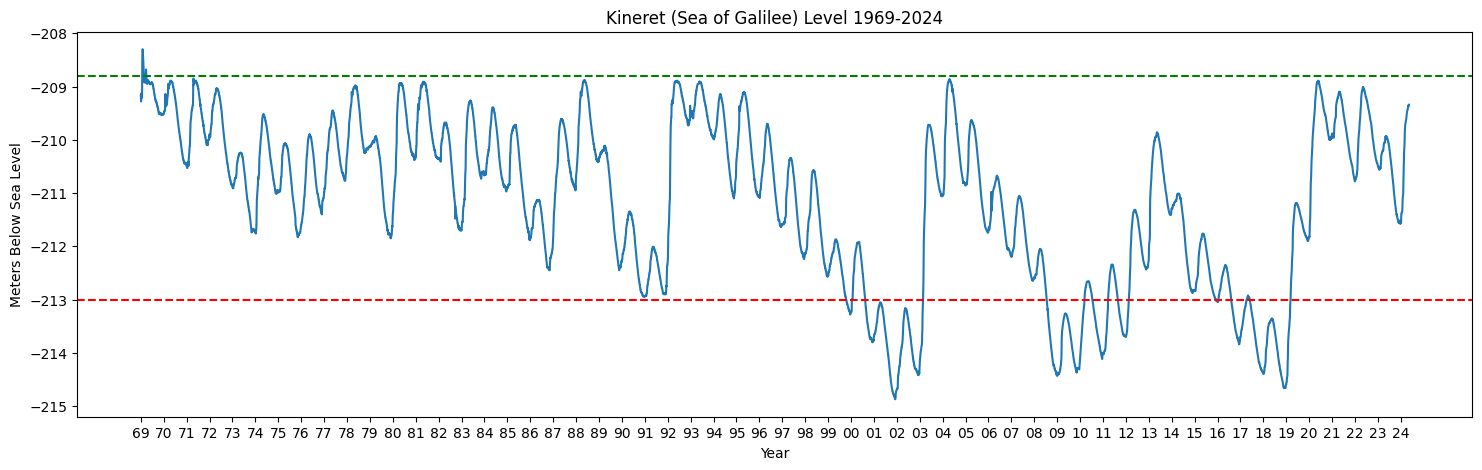

In [5]:
Years = ['69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84',
         '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '00', 
         '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16',
         '17', '18', '19', '20', '21', '22', '23', '24']
x_ticks = []

for i in range(-1, 55) :
    loc = i * 365
    x_ticks.append(loc)

plt.figure(figsize=(18, 5))
plt.plot(merged_df.date, merged_df.Level)
plt.xlabel("Year")
plt.ylabel("Meters Below Sea Level")
plt.title("Kineret (Sea of Galilee) Level 1969-2024")
plt.xticks(x_ticks, Years)
# add the "green line" (Maximum level)
plt.axhline(y=-208.80, color='g', linestyle='--')
# add the "red line" (Minimum level)
plt.axhline(y=-213, color='r', linestyle='--')
#plt.annotate('Your Text Here', xy=(10, 10), xytext=(0,0),
#            arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=12)
plt.show()

Add a column for the daily change in the Kineret level

In [6]:
change_cm = []
nRows = merged_df.shape[0]
print(nRows)
for i in range(0, nRows) :
    if i == 0 :
        change_cm.append(0.0)
    else :
        change_cm.append((merged_df.Level[i] - merged_df.Level[i-1])*100)

merged_df["change_cm"] = change_cm
merged_df.head(50)


20232


,date,Level,change_cm
0,1969-01-01,-209.17,0.0
1,1969-01-02,-209.21,-4.0
2,1969-01-03,-209.22,-1.0
3,1969-01-04,-209.25,-3.0
4,1969-01-05,-209.27,-2.0
5,1969-01-06,-209.28,-1.0
6,1969-01-07,-209.20,8.0
7,1969-01-08,-209.16,4.0
8,1969-01-09,-209.14,2.0
9,1969-01-10,-209.13,1.0


Find the largest changes in the Miflas (daily, weekly, montly)

In [7]:
# Filter the DataFrame for the rows with the 10 largest change in cm in the Miflas
miflas_copy = merged_df.copy()
miflas_copy = miflas_copy[['date', 'Level', 'change_cm']]
top_20_largest = miflas_copy.nlargest(20, 'change_cm')
print("Largest one day change in Kineret level, in descending order")
print("============================================================\n")
print(top_20_largest)
print("\n")

# Find the seven days streak where the lake rose the most
nRows = miflas_copy.shape[0]
weekly_change = []

for i in range(0, nRows) :
    if i < nRows-7 :
        seven_days_sum = miflas_copy.change_cm[i] + miflas_copy.change_cm[i+1] + \
             miflas_copy.change_cm[i+2] + miflas_copy.change_cm[i+3] + miflas_copy.change_cm[i+4] + \
                 miflas_copy.change_cm[i+5] + miflas_copy.change_cm[i+6]        
        weekly_change.append(seven_days_sum)
    else :
        weekly_change.append(0.0)

miflas_copy["weekly_change"] = weekly_change
miflas_copy["weekly_change"] = round(miflas_copy['weekly_change'], 2)
top_20_largest = miflas_copy.nlargest(20, 'weekly_change')
print("Largest 7-days changes in Kineret level, in descending order")
print("============================================================\n")
print(top_20_largest)
print("\n")

miflas_copy["year"] = miflas_copy.date.dt.year
miflas_copy["month"] = miflas_copy.date.dt.month
monthly_change = miflas_copy.groupby(["year", "month"])["change_cm"].sum()
sorted_monthly_change = monthly_change.sort_values(ascending=False)
sorted_monthly_change = round(sorted_monthly_change, 2)
print("Largest monthly change in Kineret level, in descending order")
print("============================================================\n")
print(sorted_monthly_change)
print("\n")

Largest one day change in Kineret level, in descending order

            date    Level  change_cm
13548 2006-02-03 -210.980       41.5
22    1969-01-23 -208.690       36.0
5008  1982-09-18 -211.230       25.0
18659 2020-01-09 -211.100       23.0
16087 2013-01-08 -211.500       22.0
9534  1995-02-08 -209.530       20.0
12453 2003-02-05 -213.370       20.0
4078  1980-03-02 -209.830       17.0
8401  1992-01-02 -211.920       16.0
12807 2004-01-25 -210.390       16.0
833   1971-04-14 -209.130       16.0
8436  1992-02-06 -210.290       16.0
12470 2003-02-22 -212.490       16.0
12471 2003-02-23 -212.330       16.0
12474 2003-02-26 -212.030       16.0
12806 2004-01-24 -210.550       16.0
14676 2009-03-01 -213.930       16.0
16088 2013-01-09 -211.340       16.0
8431  1992-02-01 -210.945       15.5
8432  1992-02-02 -210.790       15.5


Largest 7-days changes in Kineret level, in descending order

            date    Level  change_cm  weekly_change
8431  1992-02-01 -210.945       15.5         

Drop obvious mistakes in data 

In [8]:
merged_df.drop(13548, axis=0, inplace=True)
merged_df.drop(5008, axis=0, inplace=True)

miflas_copy = merged_df.copy()
miflas_copy = miflas_copy[['date', 'Level', 'change_cm']]
top_20_largest = miflas_copy.nlargest(20, 'change_cm')
print("Fixed largest one day change in Kineret level, in descending order")
print("==================================================================\n")
print(top_20_largest)
print("\n")

Fixed largest one day change in Kineret level, in descending order

            date    Level  change_cm
22    1969-01-23 -208.690       36.0
18659 2020-01-09 -211.100       23.0
16087 2013-01-08 -211.500       22.0
9534  1995-02-08 -209.530       20.0
12453 2003-02-05 -213.370       20.0
4078  1980-03-02 -209.830       17.0
8401  1992-01-02 -211.920       16.0
12807 2004-01-25 -210.390       16.0
833   1971-04-14 -209.130       16.0
8436  1992-02-06 -210.290       16.0
12470 2003-02-22 -212.490       16.0
12471 2003-02-23 -212.330       16.0
12474 2003-02-26 -212.030       16.0
12806 2004-01-24 -210.550       16.0
14676 2009-03-01 -213.930       16.0
16088 2013-01-09 -211.340       16.0
8431  1992-02-01 -210.945       15.5
8432  1992-02-02 -210.790       15.5
5176  1983-03-05 -210.380       15.0
5177  1983-03-06 -210.230       15.0




Add columns with 1 to 10 lag days of the lake level

In [9]:
nRows = merged_df.shape[0]

max_lag = -10
for lag in range(0, max_lag-1, -1) :
    lagged_level_change = merged_df["change_cm"].shift(lag)
    col_name = (str)(abs(lag)) + "_days_lag"
    merged_df[col_name] = lagged_level_change

merged_df.head(20)


,date,Level,change_cm,0_days_lag,1_days_lag,2_days_lag,3_days_lag,4_days_lag,5_days_lag,6_days_lag,7_days_lag,8_days_lag,9_days_lag,10_days_lag
0,1969-01-01,-209.17,0.0,0.0,-4.0,-1.0,-3.0,-2.0,-1.0,8.0,4.0,2.0,1.0,-1.0
1,1969-01-02,-209.21,-4.0,-4.0,-1.0,-3.0,-2.0,-1.0,8.0,4.0,2.0,1.0,-1.0,-1.0
2,1969-01-03,-209.22,-1.0,-1.0,-3.0,-2.0,-1.0,8.0,4.0,2.0,1.0,-1.0,-1.0,-1.0
3,1969-01-04,-209.25,-3.0,-3.0,-2.0,-1.0,8.0,4.0,2.0,1.0,-1.0,-1.0,-1.0,2.0
4,1969-01-05,-209.27,-2.0,-2.0,-1.0,8.0,4.0,2.0,1.0,-1.0,-1.0,-1.0,2.0,0.0
5,1969-01-06,-209.28,-1.0,-1.0,8.0,4.0,2.0,1.0,-1.0,-1.0,-1.0,2.0,0.0,-1.0
6,1969-01-07,-209.20,8.0,8.0,4.0,2.0,1.0,-1.0,-1.0,-1.0,2.0,0.0,-1.0,-1.0
7,1969-01-08,-209.16,4.0,4.0,2.0,1.0,-1.0,-1.0,-1.0,2.0,0.0,-1.0,-1.0,-2.0
8,1969-01-09,-209.14,2.0,2.0,1.0,-1.0,-1.0,-1.0,2.0,0.0,-1.0,-1.0,-2.0,-1.0
9,1969-01-10,-209.13,1.0,1.0,-1.0,-1.0,-1.0,2.0,0.0,-1.0,-1.0,-2.0,-1.0,-2.0


### Read the rainfall measurements file and select stations of interest from different geographical areas

In [10]:
daily_rain =  pd.read_csv("/kaggle/input/daily-rain-isr/new_isr_rain_daily_web.csv")
print(daily_rain.shape)

#drop all entries before 1969
daily_rain = daily_rain[daily_rain['year'] > 1968]
print(daily_rain.shape)

daily_rain['date'] = pd.to_datetime(daily_rain['time_obs'], format='%Y-%m-%d')

columns_to_drop = ['time_obs', 'rain_code', 'year', 'month', 'day', 'monthyear']
daily_rain.drop(columns_to_drop, axis=1, inplace=True)

daily_rain.rename(columns={'rain_06_next': 'rainfall_mm'}, inplace=True)

daily_rain = daily_rain[['stn_num', 'date', 'rainfall_mm']]

daily_rain.dropna(subset="rainfall_mm", inplace=True)

print(daily_rain.shape)

# This is where we divide the stations into geographical groups

#                     Rosh-Pina, Ayelet-Hashahar, Gadot,  Mahanaim, Yesod-Hamaala, Kiryat-Shmone, Metula,  Dan,    Neve-Ativ 
far_north_stations = {212121,    8641,            311251, 311450,   311050,        310300,        2110062, 310150, 2488708}

#                         Tel-Fares, Hushniya, Aloney-Habashan, Ortal,   Marom-Golan, Gamla, Ein-Zivan
ramat_hagolan_stations = {2496900,   2496700, 2496500,          2496261, 2496028,     4738,  2496204,
#                         Yonatan, Yahudiye  Katzrin                        
                          2493301,  2311572, 2492700}

#                       Zefat,  Meron,  Horashim, Tefen   Hurfeish                 
galil_elyon_stations = {211890, 211600, 4696,     211465, 211251}

#                         Rosh-Hanikra  Nahariya  Akko    Haifa
northen_coast_stations =  {21,          110390,   110695, 120629}

#                         Nazrat Ilit, Zipori, Yodfat, Yuvalim, Kaukab, Hosha'ya
lower_galilee_stations = {215351,      214301, 213173, 212980,  213221, 213894}

#                Dganya a, Dganya b, HaOn,   Kineret (Moshava), Beit_Yerach, Zemach 1, Zemach 2
sovev_kineret = {320502,   320650,   320350, 320405,            320550,      9111,     320703}

#                    Ra'anana, Netanya,  Kfar-Saba, Hadera
hasharon_stations = {134265,   132302,   34255,     1381}

#                    Shfaiim, Herzliya, Tel-Aviv (Sde Dov), Yafo Port, Petach-Tikva, Bat-Yam, Holon,  Rishon-LeZion
gush_dan_stations = {133742,  134060,   134945,             136329,    135452,       136600,  136730, 137015}

#                 Nahariya  Akko    Haifa, Hadera, Netanya, Tel-Aviv, Rishon-LeZion, Ashdod, Ashkelon
coast_stations = {110390,   110695, 120629, 1381,  132302,  134945,   137015,        140025, 141942}

#                     Eilat, Mitzpe-Ramon, Ein-Gedi, Ashkelon, Ashdod, Beer-Sheva
far_south_stations = {9974,  8229,         9476,     141942,   140025, 7842}


# create a dataframe for each region
daily_rain1 = daily_rain[daily_rain['stn_num'].isin(far_north_stations)]
daily_rain2 = daily_rain[daily_rain['stn_num'].isin(ramat_hagolan_stations)]
daily_rain3 = daily_rain[daily_rain['stn_num'].isin(galil_elyon_stations)]
daily_rain4 = daily_rain[daily_rain['stn_num'].isin(lower_galilee_stations)]
daily_rain5 = daily_rain[daily_rain['stn_num'].isin(northen_coast_stations)] 
daily_rain6 = daily_rain[daily_rain['stn_num'].isin(sovev_kineret)]
daily_rain7 = daily_rain[daily_rain['stn_num'].isin(hasharon_stations)]
daily_rain8 = daily_rain[daily_rain['stn_num'].isin(gush_dan_stations)]
daily_rain9 = daily_rain[daily_rain['stn_num'].isin(coast_stations)]
daily_rain10 = daily_rain[daily_rain['stn_num'].isin(far_south_stations)]

# Katzrin
daily_rain11 = daily_rain[daily_rain['stn_num'] == 2492700]

# Har Meron
daily_rain12 = daily_rain[daily_rain['stn_num'] == 211600]

# Neve Ativ
daily_rain13 = daily_rain[daily_rain['stn_num'] == 2488708]

# Tefen
daily_rain14 = daily_rain[daily_rain['stn_num'] == 211465]
                          
# Dganya-Alef
daily_rain15 = daily_rain[daily_rain['stn_num'] == 320502]
                          
daily_rain1 = daily_rain1.assign(area_name = 'Far North')
daily_rain2 = daily_rain2.assign(area_name = 'Ramat-Hagolan')
daily_rain3 = daily_rain3.assign(area_name = 'Upper Gallilee')
daily_rain4 = daily_rain4.assign(area_name = 'Lower Galilee')
daily_rain5 = daily_rain5.assign(area_name = 'Northen Coast')
daily_rain6 = daily_rain6.assign(area_name = 'Sovev Kineret')
daily_rain7 = daily_rain7.assign(area_name = 'HaSharon')
daily_rain8 = daily_rain8.assign(area_name = 'Gush Dan')
daily_rain9 = daily_rain9.assign(area_name = 'Israel Coast')
daily_rain10 = daily_rain10.assign(area_name = 'Far South')

daily_rain11 = daily_rain11.assign(area_name = 'Katzrin')
daily_rain12 = daily_rain12.assign(area_name = 'Meron')
daily_rain13 = daily_rain13.assign(area_name = 'Neve-Ativ')
daily_rain14 = daily_rain14.assign(area_name = 'Tefen')
daily_rain15 = daily_rain15.assign(area_name = 'Dganya Alef')

# create a list of all the regions dataframes 
daily_rain_per_region_dfs_list = []

daily_rain_per_region_dfs_list.append(daily_rain1)
daily_rain_per_region_dfs_list.append(daily_rain2)
daily_rain_per_region_dfs_list.append(daily_rain3)
daily_rain_per_region_dfs_list.append(daily_rain4)
daily_rain_per_region_dfs_list.append(daily_rain5)
daily_rain_per_region_dfs_list.append(daily_rain6)
daily_rain_per_region_dfs_list.append(daily_rain7)
daily_rain_per_region_dfs_list.append(daily_rain8)
daily_rain_per_region_dfs_list.append(daily_rain9)
daily_rain_per_region_dfs_list.append(daily_rain10)
daily_rain_per_region_dfs_list.append(daily_rain11)
daily_rain_per_region_dfs_list.append(daily_rain12)
daily_rain_per_region_dfs_list.append(daily_rain13)
daily_rain_per_region_dfs_list.append(daily_rain14)
daily_rain_per_region_dfs_list.append(daily_rain15)

daily_rain1.head(20)

(1925307, 8)
(1311588, 8)
(1301812, 3)


,stn_num,date,rainfall_mm,area_name
966154,212121,1973-10-31,28.3,Far North
966155,212121,1973-11-01,4.6,Far North
966156,212121,1973-11-11,13.3,Far North
966157,212121,1973-11-12,35.6,Far North
966158,212121,1973-11-13,25.0,Far North
966159,212121,1973-11-14,0.4,Far North
966160,212121,1973-11-16,1.1,Far North
966161,212121,1973-11-22,29.2,Far North
966162,212121,1973-11-23,5.5,Far North
966163,212121,1973-11-30,2.0,Far North


In [11]:
# Merge the DailyRain per geographical area DataFrames with the Miflas Level DataFrame

dailyRainPerRegionVsLevelDFsList = []

for i in range(1, 16) :
    DailyRainVsLevel = pd.merge(daily_rain_per_region_dfs_list[i-1], merged_df, on='date', how='left')
    dailyRainPerRegionVsLevelDFsList.append(DailyRainVsLevel)
    dailyRainPerRegionVsLevelDFsList[i-1] = dailyRainPerRegionVsLevelDFsList[i-1][['stn_num', 'area_name', 'date', 'rainfall_mm', 'Level', 'change_cm',
                                                    '0_days_lag', '1_days_lag', '2_days_lag', '3_days_lag', '4_days_lag', '5_days_lag',
                                                        '6_days_lag', '7_days_lag', '8_days_lag', '9_days_lag', '10_days_lag']]
    print(i, dailyRainPerRegionVsLevelDFsList[i-1].shape)

dailyRainPerRegionVsLevelDFsList[0].head(20)

1 (11986, 17)
2 (9204, 17)
3 (7471, 17)
4 (6934, 17)
5 (5842, 17)
6 (11123, 17)
7 (2494, 17)
8 (10577, 17)
9 (11738, 17)
10 (1826, 17)
11 (816, 17)
12 (2740, 17)
13 (1320, 17)
14 (1372, 17)
15 (1324, 17)


,stn_num,area_name,date,rainfall_mm,Level,change_cm,0_days_lag,1_days_lag,2_days_lag,3_days_lag,4_days_lag,5_days_lag,6_days_lag,7_days_lag,8_days_lag,9_days_lag,10_days_lag
0,212121,Far North,1973-10-31,28.3,-211.72,-1.0,-1.0,-2.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,212121,Far North,1973-11-01,4.6,-211.74,-2.0,-2.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,212121,Far North,1973-11-11,13.3,-211.70,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,212121,Far North,1973-11-12,35.6,-211.70,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,212121,Far North,1973-11-13,25.0,-211.70,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,212121,Far North,1973-11-14,0.4,-211.69,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,212121,Far North,1973-11-16,1.1,-211.69,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7,212121,Far North,1973-11-22,29.2,-211.68,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.0
8,212121,Far North,1973-11-23,5.5,-211.68,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0
9,212121,Far North,1973-11-30,2.0,-211.69,-1.0,-1.0,0.0,0.0,0.0,-1.0,0.0,-1.0,0.0,1.0,1.0,0.0


Create a correlation dataframe per region with 1 to 10 days lag time and display in seperate bar charts

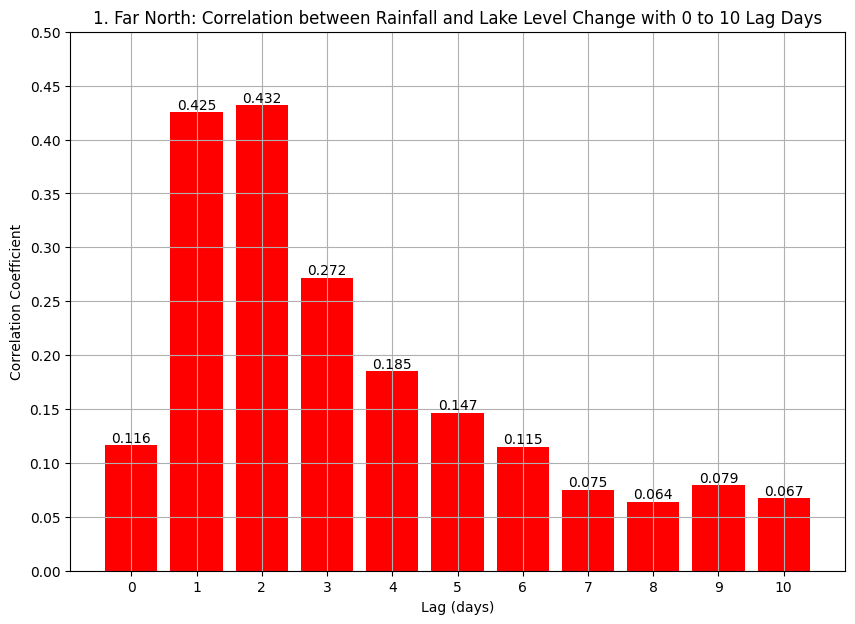

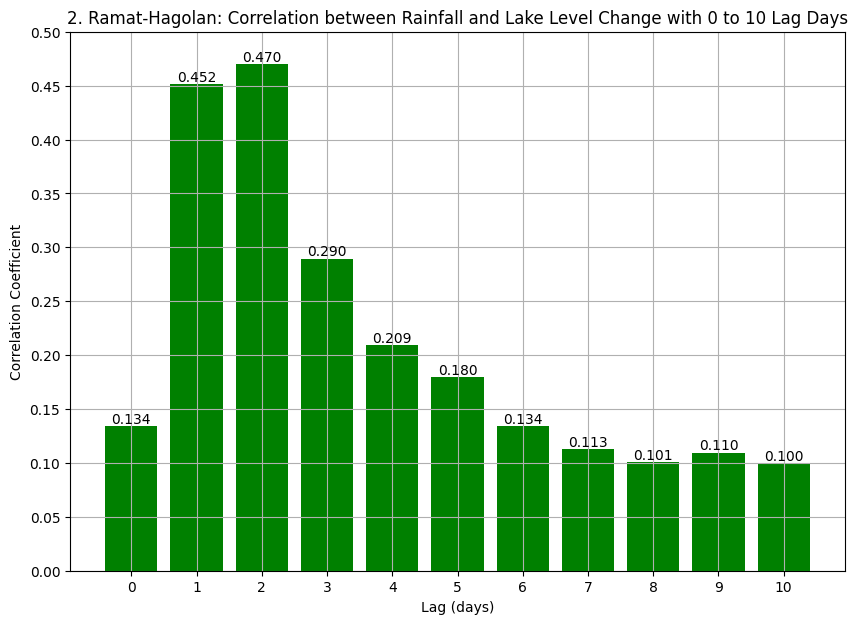

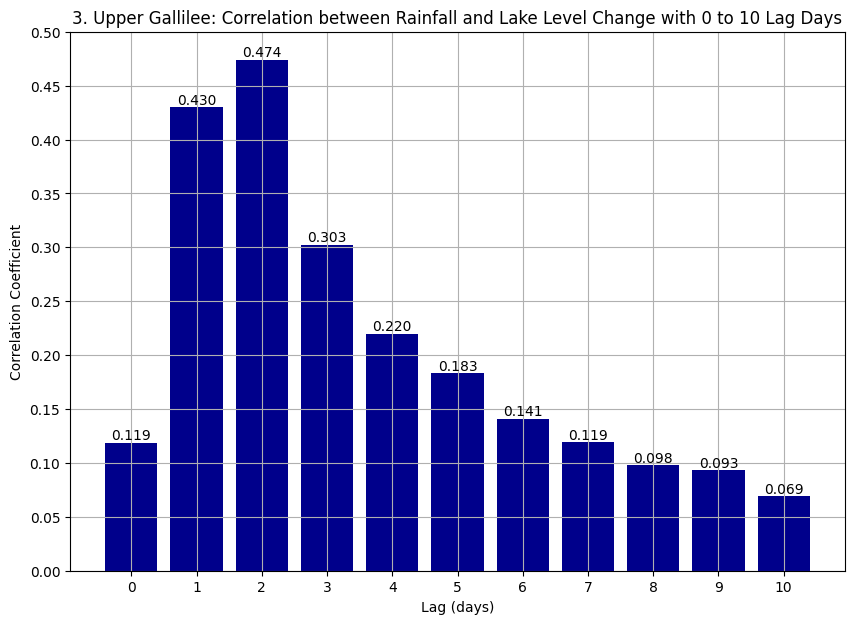

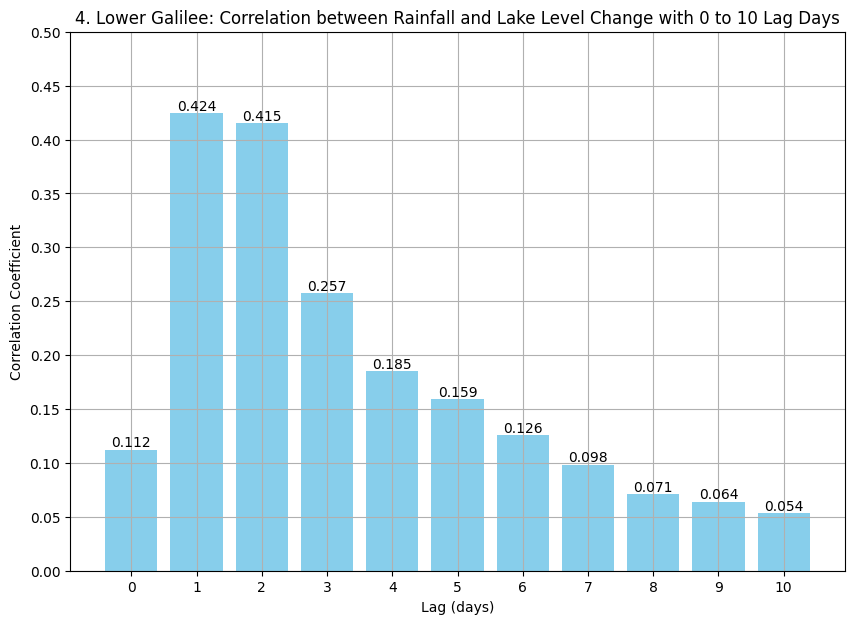

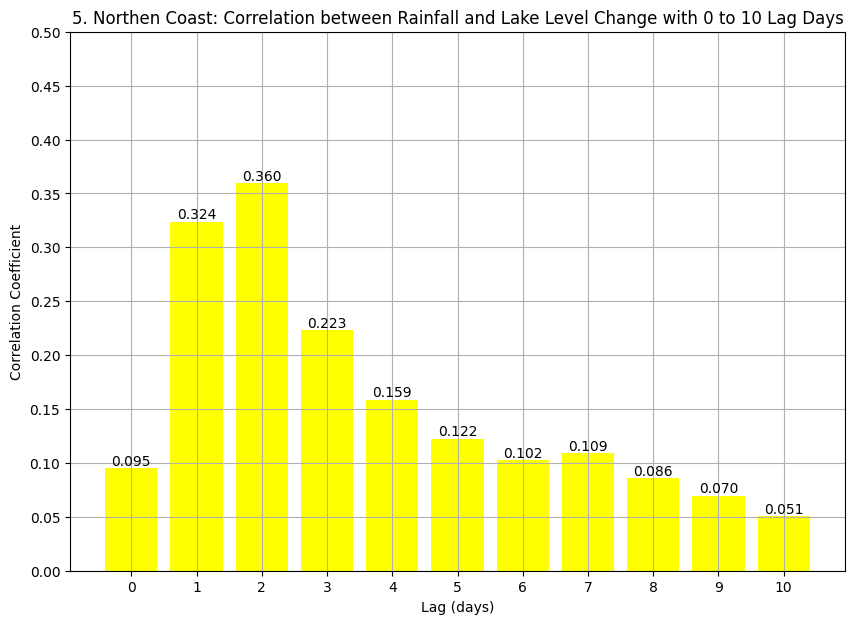

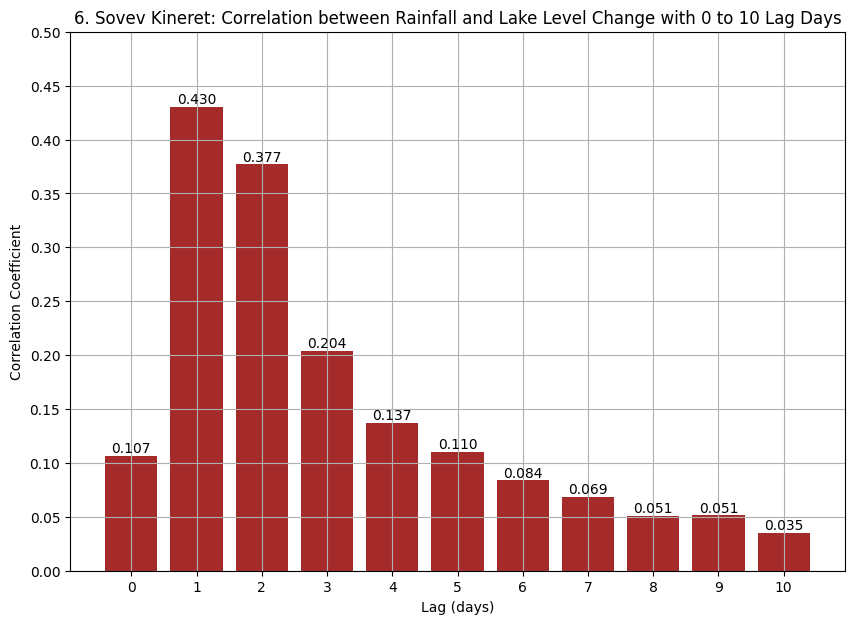

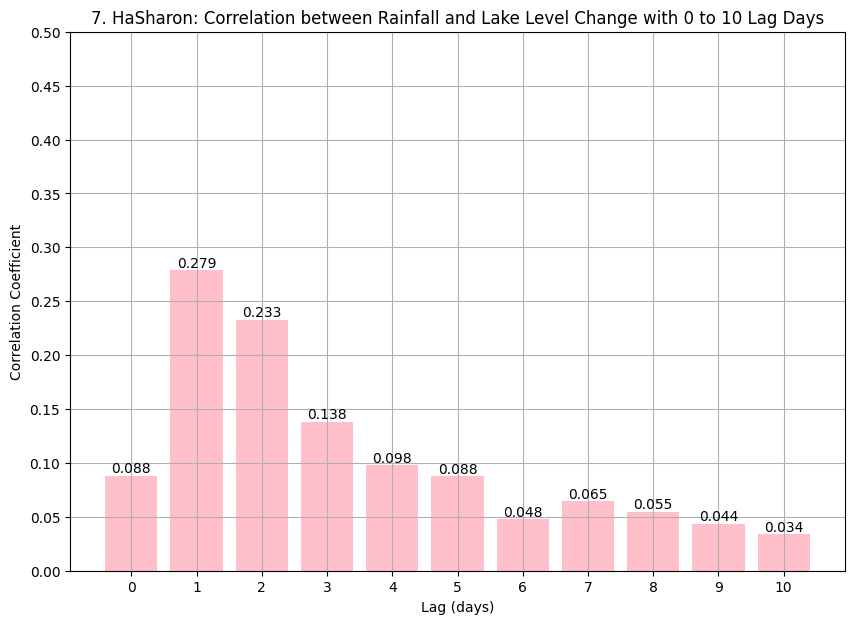

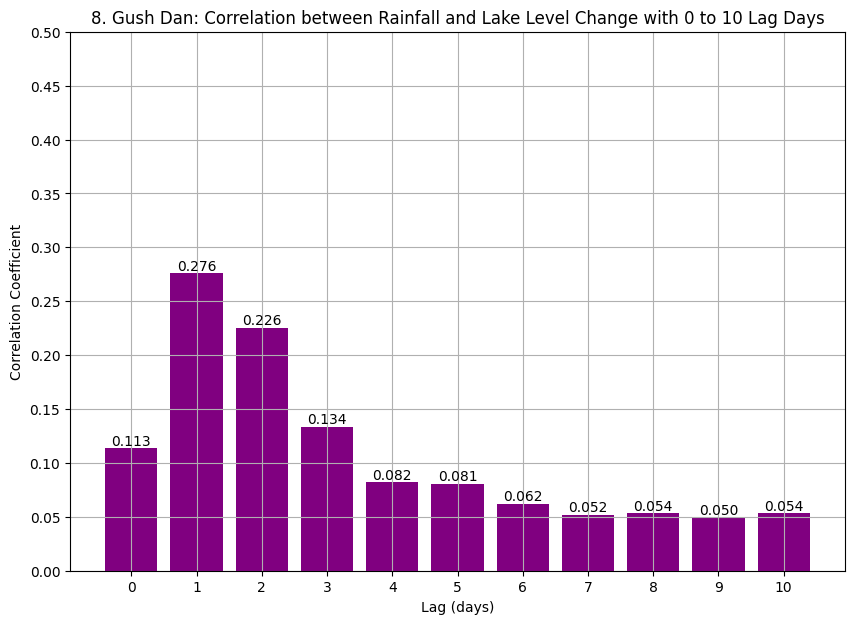

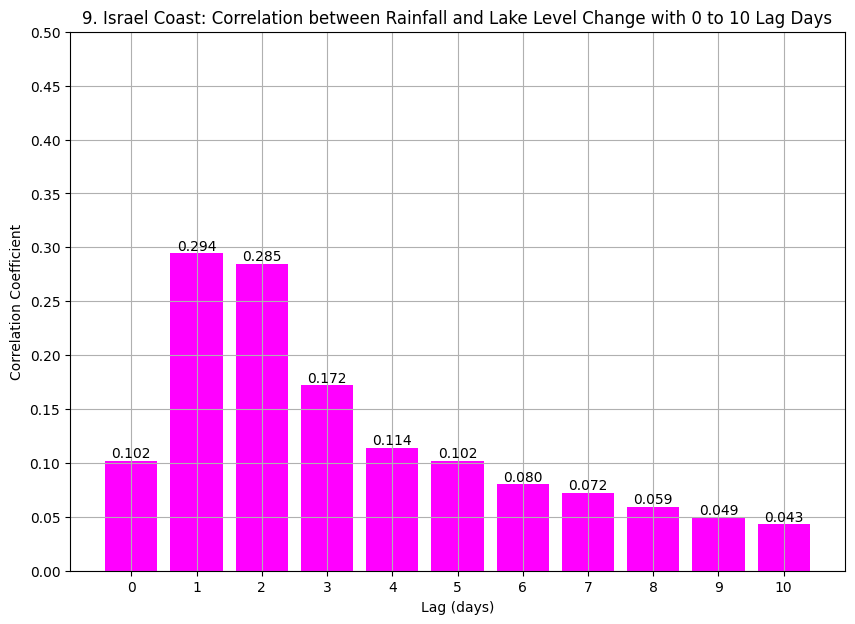

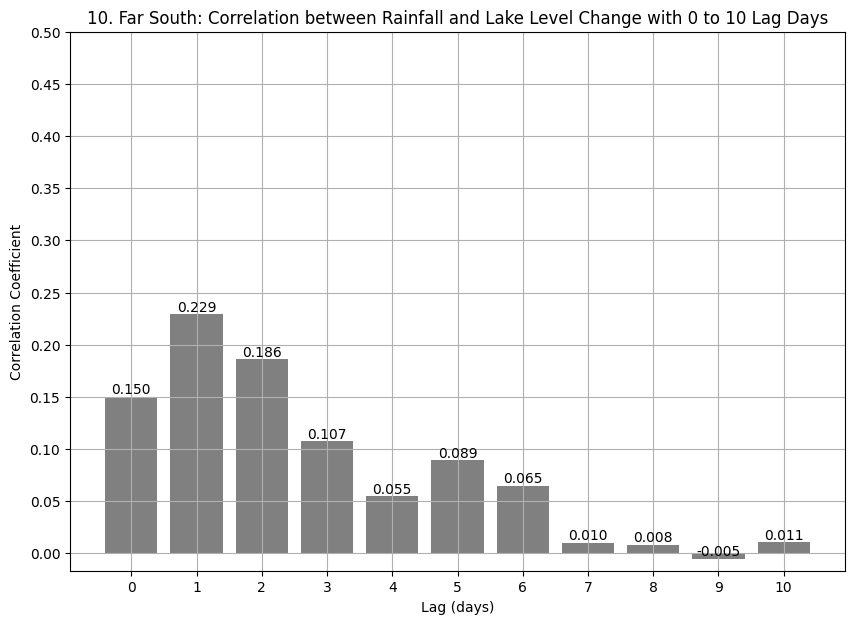

In [12]:
max_lag = 10
correlations = []
bar_colors = ['#000000', 'red', 'green', 'darkblue', 'skyblue', 'yellow', 'brown', 'pink', 'purple', 'magenta', 'gray']

for i in range (1, 11) :
    area_name = dailyRainPerRegionVsLevelDFsList[i-1].loc[0, 'area_name']
    correlations.clear()
    for lag in range(max_lag + 1):
        col_name = str(lag) + "_days_lag"
        shifted_rain = dailyRainPerRegionVsLevelDFsList[i-1][col_name]
        correlation1 = dailyRainPerRegionVsLevelDFsList[i-1]['rainfall_mm'].corr(shifted_rain)
        correlations.append(correlation1)

    # Create a DataFrame for the results
    correlation_df = pd.DataFrame({'Lag': range(max_lag + 1), 'Correlation': correlations})

    # Plot the correlations
    #plt.figure(figsize=(10, 7))
    #plt.bar(correlation_df['Lag'], correlation_df['Correlation'], color=bar_colors[i])
    
    fig, ax = plt.subplots(figsize=(10, 7))
    bars = ax.bar(correlation_df['Lag'], correlation_df['Correlation'], color=bar_colors[i])
    
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,  # X position of the text
            height,                               # Y position of the text
           f'{height:.3f}',                          # Text to display
            ha='center',                          # Horizontal alignment
            va='bottom'                           # Vertical alignment
            )
    
    plt.xlabel('Lag (days)')
    plt.ylabel('Correlation Coefficient')
    header = (str)(i) + ". " + (str)(area_name) + ": Correlation between Rainfall and Lake Level Change with 0 to 10 Lag Days"
    plt.title(header)
    plt.xticks(range(max_lag + 1))  # Ensure all lags are shown on the x-axis
    yticks = np.arange(0, 0.55, 0.05)
    plt.yticks(yticks)
    plt.grid(True)

Display all the correlation graphs in one multiple bars plot

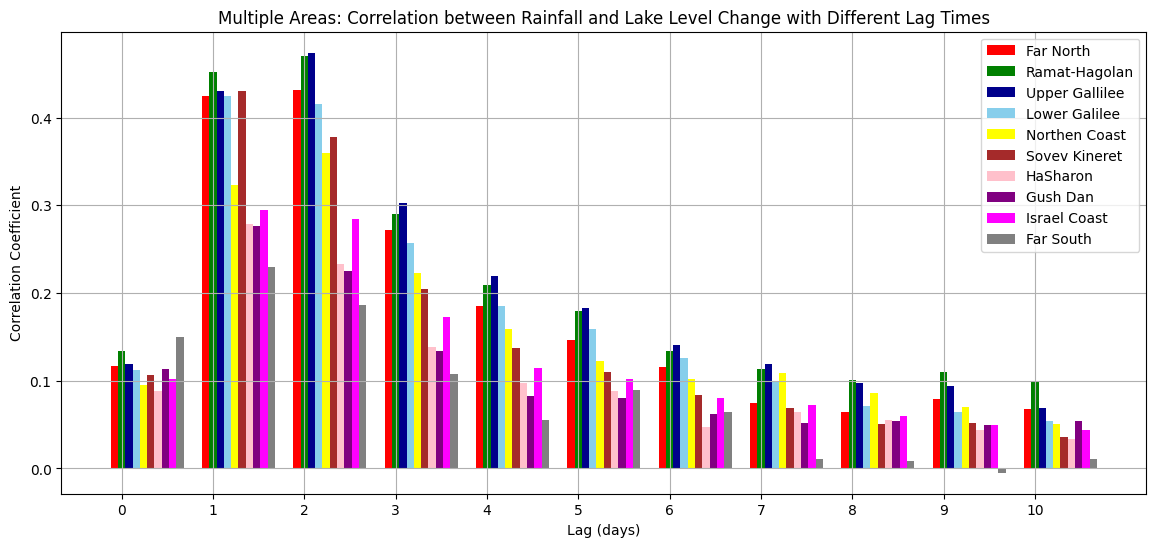

In [13]:
max_lag = 10
area_names = []

for i in range (0, 10) :
    area_names.append(dailyRainPerRegionVsLevelDFsList[i].loc[0, 'area_name'])

locations = area_names
rain_dfs = dailyRainPerRegionVsLevelDFsList

correlations = {location: [] for location in locations}

for lag in range(max_lag + 1):
    lag_column_name = (str)(lag) + "_days_lag"
    for location, rain_df in zip(locations, rain_dfs):
        lag_level_change = rain_df[lag_column_name]
        correlation = rain_df['rainfall_mm'].corr(lag_level_change)
        correlations[location].append(correlation)

# Create a DataFrame for the results
correlation_df = pd.DataFrame(correlations)
correlation_df['Lag'] = range(max_lag + 1)

# Plot the correlations
fig, ax = plt.subplots(figsize=(14, 6))

bar_width = 0.08
lags = correlation_df['Lag']
indices = np.arange(len(lags))

# Plot each location's correlations
for i, location in enumerate(locations):
    ax.bar(indices + i * bar_width, correlation_df[location], bar_width, label=location, color=bar_colors[i+1])

ax.set_xlabel('Lag (days)')
ax.set_ylabel('Correlation Coefficient')
ax.set_title('Multiple Areas: Correlation between Rainfall and Lake Level Change with Different Lag Times')
ax.set_xticks(indices + bar_width)
ax.set_xticklabels(lags)
ax.legend()
ax.grid(True)

plt.show()

View selected stations' correlations in one graph

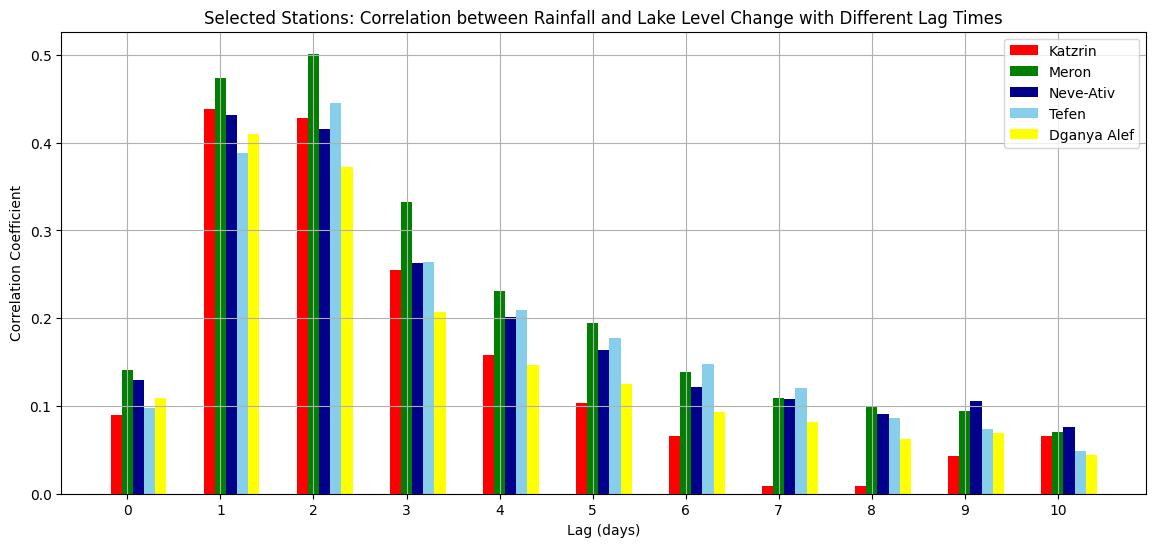

In [14]:
max_lag = 10
area_names.clear()

for i in range (10, 15) :
    area_names.append(dailyRainPerRegionVsLevelDFsList[i].loc[0, 'area_name'])

locations = area_names
rain_dfs = [dailyRainPerRegionVsLevelDFsList[10], dailyRainPerRegionVsLevelDFsList[11],
                dailyRainPerRegionVsLevelDFsList[12], dailyRainPerRegionVsLevelDFsList[13],
                    dailyRainPerRegionVsLevelDFsList[14]]

correlations = {location: [] for location in locations}

for lag in range(max_lag + 1):
    lag_column_name = (str)(lag) + "_days_lag"
    for location, rain_df in zip(locations, rain_dfs):
        lag_level_change = rain_df[lag_column_name]
        correlation = rain_df['rainfall_mm'].corr(lag_level_change)
        correlations[location].append(correlation)

# Create a DataFrame for the results
correlation_df = pd.DataFrame(correlations)
correlation_df['Lag'] = range(max_lag + 1)

# Plot the correlations
fig, ax = plt.subplots(figsize=(14, 6))

bar_width = 0.12
lags = correlation_df['Lag']
indices = np.arange(len(lags))

# Plot each location's correlations
for i, location in enumerate(locations):
    ax.bar(indices + i * bar_width, correlation_df[location], bar_width, label=location, color=bar_colors[i+1])

ax.set_xlabel('Lag (days)')
ax.set_ylabel('Correlation Coefficient')
ax.set_title('Selected Stations: Correlation between Rainfall and Lake Level Change with Different Lag Times')
ax.set_xticks(indices + bar_width)
ax.set_xticklabels(lags)
ax.legend()
ax.grid(True)

plt.show()

## Create a scatter plot with trend line for Har Meron

y = 0.72x + 6.03


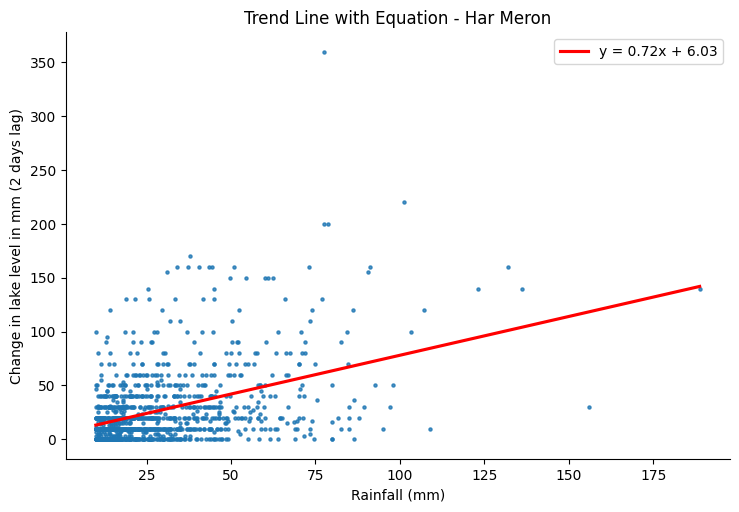

In [15]:
from scipy.stats import linregress

DailyRainHarMeron = dailyRainPerRegionVsLevelDFsList[11]
DailyRainHarMeron['2d_lag_mm'] = DailyRainHarMeron['2_days_lag'] * 10
DailyRainFiltered = DailyRainHarMeron[DailyRainHarMeron['rainfall_mm'] >= 10]
DailyRainFiltered = DailyRainFiltered[DailyRainFiltered['2_days_lag'] >= 0.0]

#seventy_fifth_percent  = DailyRainFiltered['2d_lag_mm'].quantile(0.75)
#twenty_fifth_percent = DailyRainFiltered['2d_lag_mm'].quantile(0.25)
#two_days_lag_iqr = seventy_fifth_percent - twenty_fifth_percent
#top = seventy_fifth_percent + (two_days_lag_iqr * 1.5)
#print(twenty_fifth_percent, seventy_fifth_percent, top)
#DailyRain_filtered_from_outliers = DailyRainFiltered[DailyRainFiltered['2d_lag_mm'] <= top]

# Fit linear regression model
slope, intercept, r_value, p_value, std_err = linregress(DailyRainFiltered['rainfall_mm'],
                                                             DailyRainFiltered['2d_lag_mm'])

# Calculate the equation of the trend line
trend_line_eq = f'y = {slope:.2f}x + {intercept:.2f}'
print(trend_line_eq)

sns.lmplot(x='rainfall_mm', y='2d_lag_mm', data=DailyRainFiltered, ci=None, scatter_kws={'s': 5, 'alpha': 0.8},
           line_kws={'color': 'red', 'label':trend_line_eq}, height=5, aspect=1.5)

plt.xlabel("Rainfall (mm)")
plt.ylabel("Change in lake level in mm (2 days lag)")
plt.legend()
plt.title('Trend Line with Equation - Har Meron')
plt.show()

# Conclusions
The project was aimed to find the geographical area with the highest correlation between the measured rainfall and the change in the level of lake Kineret. The answer from this project is that two areas prvide the best correlation: The Upper Galilee (0.474) and the Golan Heights (0.47).

The best correlation for these two areas is found in 2 days lag between rainfall measurements and the change in the Kineret level. Other more southerly areas showed the best correlation in a one day lag between the measurements. This makes sense, since during winter, when a rain system passes Israel, the further south you go, the later the rain starts.

Additional work can be done to find the single station with highest correlation, or to find correlation between rainfall total for several consecutive days and the level change of the Kineret.